In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import time
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler,LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D,GlobalAveragePooling1D,BatchNormalization,GRU, Dense, Dropout, Flatten, TimeDistributed
import os
from tensorflow.keras.utils import to_categorical
import copy

ModuleNotFoundError: No module named 'seaborn'

In [29]:
def load_dataset():
  labels=[]
  data=[]
  folder_path = "/content/drive/MyDrive/accel"
  for f in os.listdir(folder_path):
    file_path=file_path = os.path.join(folder_path, f)
    with open(file_path, "r") as f:
        for line in f:
            line = line.strip().replace(";", "")  # remove trailing ;
            parts = line.split(",")
            if len(parts) >= 6:
                label = parts[1]  # 2nd col = label
                ax, ay, az = map(float, parts[3:6])  # take 4th,5th,6th cols
                labels.append(label)
                data.append([ax, ay, az])

  # Convert to numpy arrays
  data = np.array(data)       # shape (datapoints, 3)
  labels = np.array(labels)   # shape (datapoints,)


  valid_labels = {"A", "B", "E", "P", "R", "O"}
  mask = np.isin(labels, list(valid_labels))
  data1 = data[mask]
  labels1 = labels[mask]

  valid_labels1={"A"}
  mask1 = np.isin(labels, list(valid_labels1))
  data2 = data[mask1]
  labels2 = labels[mask1]

  window_s_x=[]
  window_s_y=[]

  y2=[]
  for i in range(data2.shape[0]):
    y2.append(data2[i])
    if((i+1)%200 ==0):
      window_s_x.append(y2)
      window_s_y.append(0)
      y2=[]


  valid_labels2={"B"}
  mask2 = np.isin(labels, list(valid_labels2))
  data3 = data[mask2]
  labels3 = labels[mask2]

  y2=[]
  for i in range(data3.shape[0]):
    y2.append(data3[i])
    if((i+1)%200 ==0):
      window_s_x.append(y2)
      window_s_y.append(1)
      y2=[]


  valid_labels3={"E"}
  mask3 = np.isin(labels, list(valid_labels3))
  data4 = data[mask3]
  labels4 = labels[mask3]

  y2=[]
  for i in range(data4.shape[0]):
    y2.append(data4[i])
    if((i+1)%200 ==0):
      window_s_x.append(y2)
      window_s_y.append(2)
      y2=[]


  valid_labels4={"P","O","R"}
  mask4 = np.isin(labels, list(valid_labels4))
  data5 = data[mask4]
  labels5 = labels[mask4]

  y2=[]
  for i in range(data5.shape[0]):
    y2.append(data5[i])
    if((i+1)%200 ==0):
      window_s_x.append(y2)
      window_s_y.append(3)
      y2=[]
  return np.array(window_s_x),np.array(window_s_y)

X,Y=load_dataset()

In [54]:
Y.shape[0]

6320

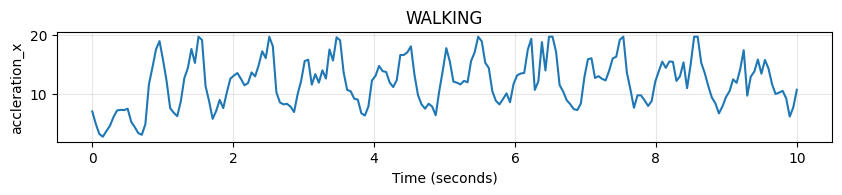

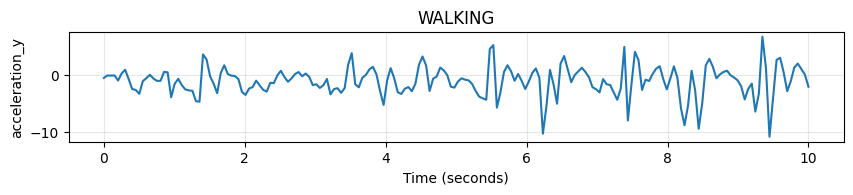

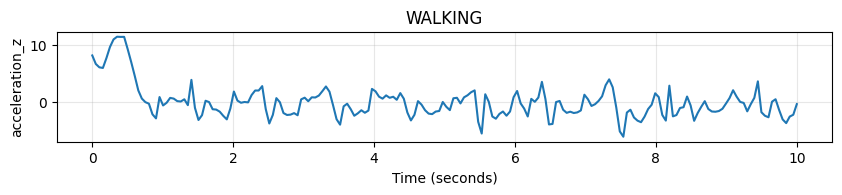

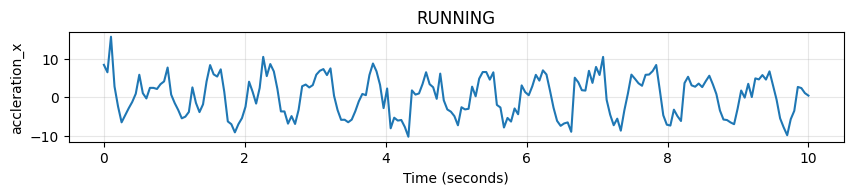

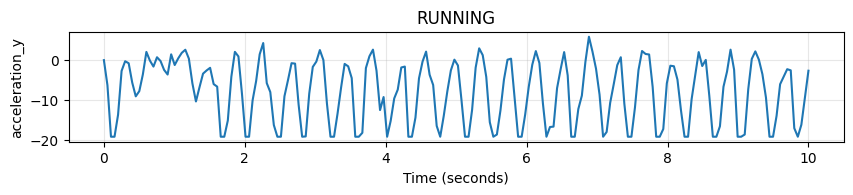

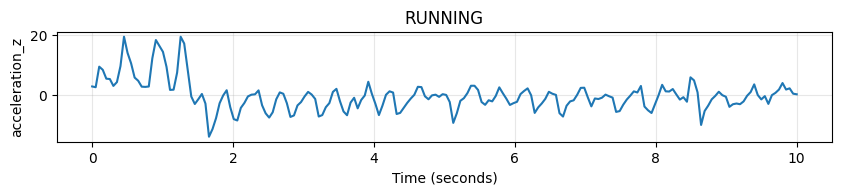

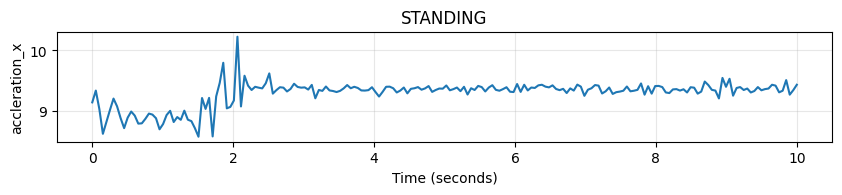

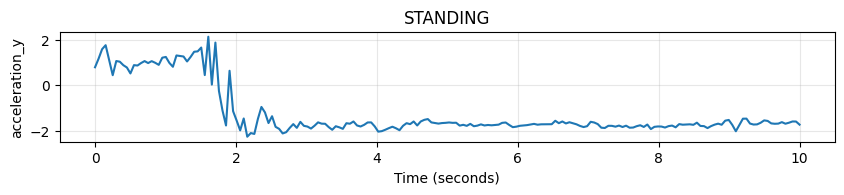

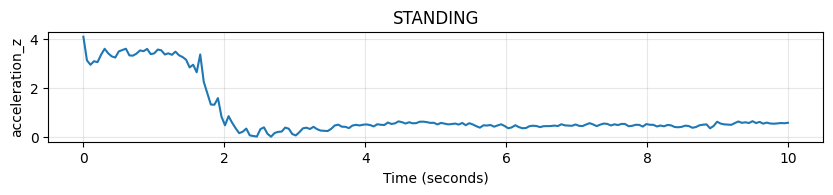

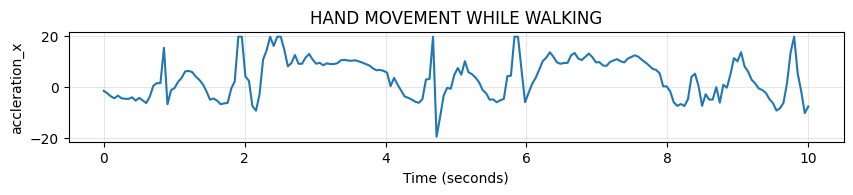

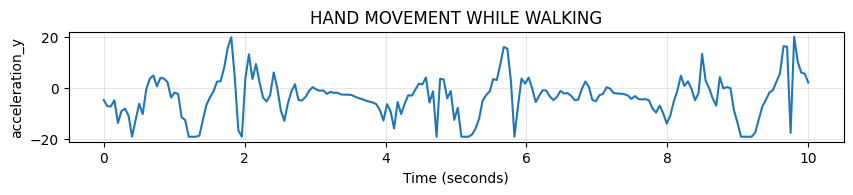

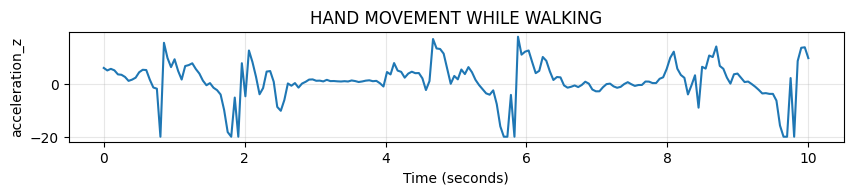

In [34]:


def visualize_one_signal_from_each_class(signals, labels, no_of_classes):
    class_name = ["WALKING", "RUNNING", "STANDING","HAND MOVEMENT WHILE WALKING"]
    t = np.linspace(0, 10, 200)

    for class_idx in range(no_of_classes):
        idx = np.where(labels == class_idx)[0]
        if len(idx) == 0:
            print(f"No samples for class {class_name[class_idx]}")
            continue

        first_index_only = idx[0]

        y4=signals[first_index_only][:,0]
        plt.figure(figsize=(10,10))
        plt.subplot(6,1,4)
        plt.plot(t,y4)
        plt.title(f'{class_name[class_idx]}')
        plt.xlabel("Time (seconds)")
        plt.ylabel("accleration_x")
        plt.grid(True, alpha=0.3)

        y5=signals[first_index_only][:,1]
        plt.figure(figsize=(10,10))
        plt.subplot(6,1,5)
        plt.plot(t,y5)
        plt.title(f'{class_name[class_idx]}')
        plt.xlabel("Time (seconds)")
        plt.ylabel("acceleration_y")
        plt.grid(True, alpha=0.3)

        y6=signals[first_index_only][:,2]
        plt.figure(figsize=(10,10))
        plt.subplot(6,1,6)
        plt.plot(t,y6)
        plt.title(f'{class_name[class_idx]}')
        plt.xlabel("Time (seconds)")
        plt.ylabel("acceleration_z")
        plt.grid(True, alpha=0.3)
        plt.show()

visualize_one_signal_from_each_class(X,Y,4)




In [42]:
def Z_score_Normalization(sig):
  signals=copy.deepcopy(sig)
  for i in range(len(signals)):
    sns1=signals[i]
    for j in range(3):
      sns=sns1[:,j]
      m=np.mean(sns)
      std=np.std(sns)
      normal=(sns-m)/std
      sns1[:,j]=normal
    signals[i]=sns1
  return signals

normalized=Z_score_Normalization(X)
def butterworth(sig,cutoff,order,sampling_frequency):
  signals=copy.deepcopy(sig)
  wn=(2*cutoff)/(sampling_frequency)
  b,a=butter(order,wn,btype='low',analog=False)
  for i in range(len(signals)):
    sns1=signals[i]
    for j in range(3):
      sns=sns1[:,j]
      filter_signal=filtfilt(b,a,sns)
      sns1[:,j]=filter_signal
    signals[i]=sns1
  return signals
filtered_signal=butterworth(normalized,20,4,70)

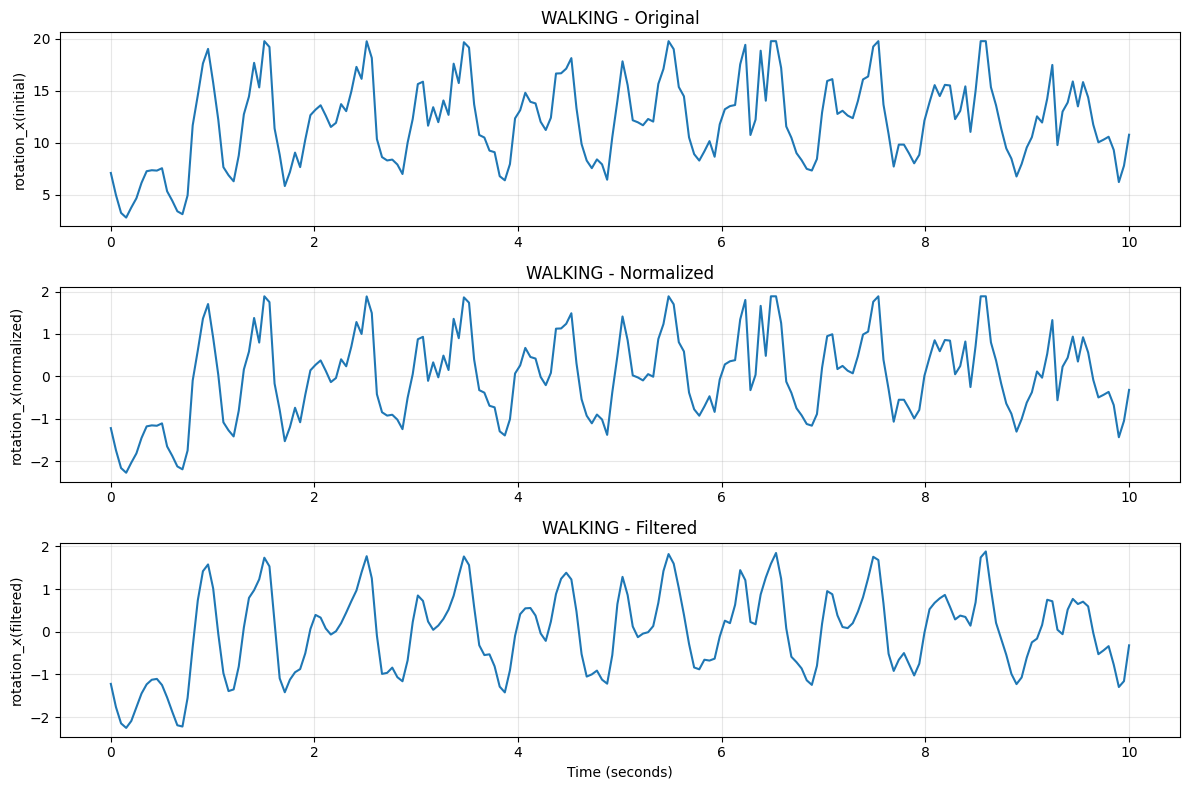

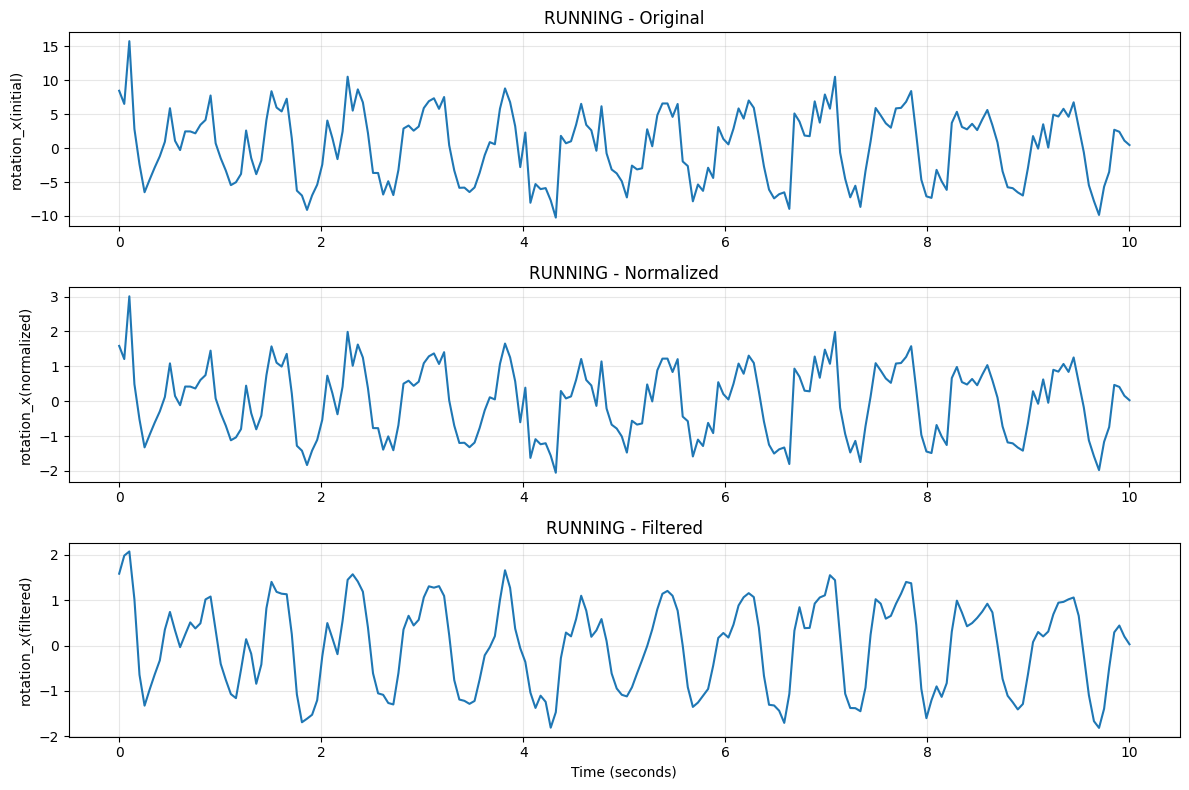

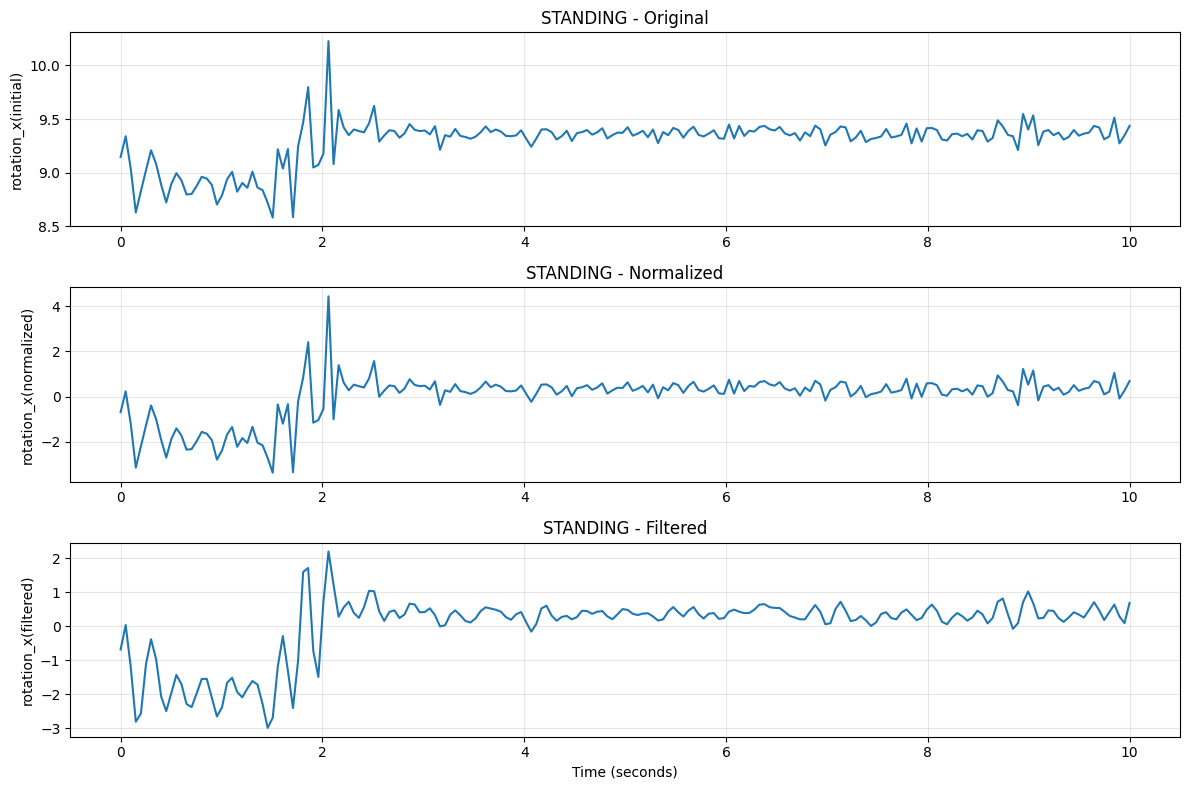

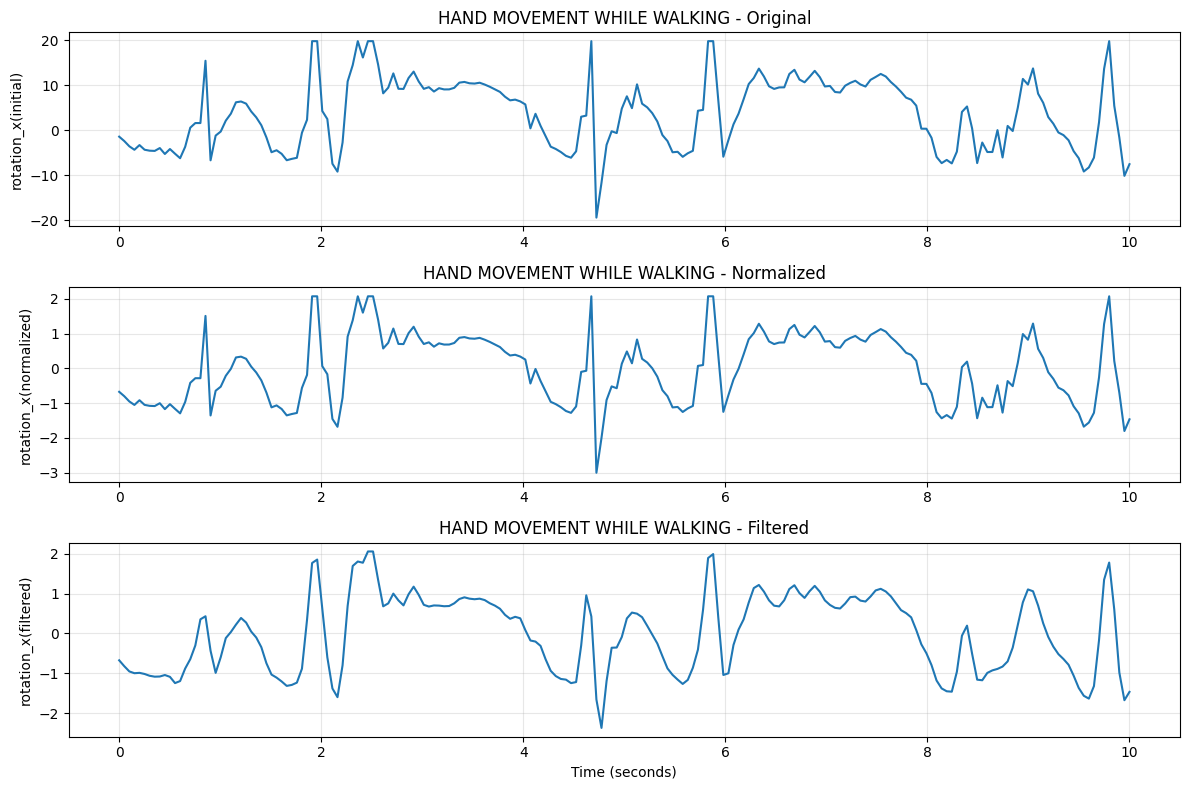

In [43]:
def visualize_one_signal_from_each_class_after_processing(signals, labels, normalized, filtered_signal, no_of_classes):
    class_name = ["WALKING", "RUNNING", "STANDING","HAND MOVEMENT WHILE WALKING"]
    t = np.linspace(0, 10, 200)

    for class_idx in range(no_of_classes):
        idx = np.where(labels == class_idx)[0]
        if len(idx) == 0:
            print(f"No samples for class {class_name[class_idx]}")
            continue

        first_index_only = idx[0]

        plt.figure(figsize=(12, 8))  # Create figure ONCE

        # Subplot 1 - Original
        plt.subplot(3,1,1)
        y1 = signals[first_index_only][:,0]
        plt.plot(t, y1)
        plt.title(f'{class_name[class_idx]} - Original')
        plt.ylabel("rotation_x(initial)")
        plt.grid(True, alpha=0.3)

        # Subplot 2 - Normalized
        plt.subplot(3,1,2)
        y2 = normalized[first_index_only][:,0]
        plt.plot(t, y2)
        plt.title(f'{class_name[class_idx]} - Normalized')
        plt.ylabel("rotation_x(normalized)")
        plt.grid(True, alpha=0.3)

        # Subplot 3 - Filtered
        plt.subplot(3,1,3)
        y3 = filtered_signal[first_index_only][:,0]
        plt.plot(t, y3)
        plt.title(f'{class_name[class_idx]} - Filtered')
        plt.xlabel("Time (seconds)")
        plt.ylabel("rotation_x(filtered)")
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

visualize_one_signal_from_each_class_after_processing(X,Y,normalized,filtered_signal,4)

In [45]:
X_final=np.array(filtered_signal)
y_int=np.array(Y)
Y_final=to_categorical(y_int,num_classes=4)

In [52]:
def create_cnn_model(input_shape=(200,3),num_classes=4):
  model=Sequential([
      tf.keras.layers.Input(shape=input_shape),
      Conv1D(filters=32,kernel_size=3,activation='relu',name='conv1d_1'),
      MaxPooling1D(pool_size=2,name='maxpool_1'),
      BatchNormalization(name='bn1'),

      Conv1D(filters=64,kernel_size=3,activation='relu',name='conv1d_2'),
      MaxPooling1D(pool_size=2,name='maxpool_2'),
      BatchNormalization(name='bn2'),

      Dropout(0.3, name='dropout_1'),

      Conv1D(filters=128,kernel_size=3,activation='relu',name='conv1d_3'),
      MaxPooling1D(pool_size=2,name='maxpool_3'),
      BatchNormalization(name='bn3'),

      Conv1D(filters=256,kernel_size=3,activation='relu',name='conv1d_4'),
      MaxPooling1D(pool_size=2,name='maxpool_4'),
      BatchNormalization(name='bn4'),

      Dropout(0.5, name='dropout_2'),
      GlobalAveragePooling1D(name='global_avg_pool'),
      Dense(64, activation='relu', name='fc_1'),
      Dense(num_classes, activation='softmax', name='output')
  ])
  model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy']
    )
  return model

def evaluate_fold(model,X_test,Y_test):
  y_predicted_probabilities=model.predict(X_test,verbose=0)
  y_pred=np.argmax(y_predicted_probabilities,axis=1)
  y_true=np.argmax(Y_test,axis=1)

  accuracy=accuracy_score(y_true,y_pred)
  precision=precision_score(y_true,y_pred,average='macro',zero_division=0)
  recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
  f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

  metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,}

  return metrics

In [50]:
def train_single_fold(X_train,Y_train,X_val,Y_val,epochs=60,batch_size=32):
  model=create_cnn_model()
  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15,
            restore_best_weights=True,
            verbose=0)]
  start_time=time.time()
  history = model.fit(
        X_train, Y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, Y_val),
        callbacks=callbacks,
        verbose=0
    )
  training_time=time.time()-start_time
  return model,history


In [53]:
from sklearn.model_selection import train_test_split

# First split: 80% train, 20% test (with randomization)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_final, Y_final,
    test_size=0.2,
    random_state=42,  # For reproducibility
    stratify=np.argmax(Y_final, axis=1)  # Ensures balanced classes in both splits
)

# Second split: 80% train, 20% validation from the training set
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=123,  # Different seed
    stratify=np.argmax(Y_train, axis=1)
)

# Now train multiple iterations
no_of_iterations = 5
accuracies = []

for i in range(no_of_iterations):
    model, history = train_single_fold(X_train, Y_train, X_val, Y_val, 60, 32)
    metrics = evaluate_fold(model, X_test, Y_test)
    accuracies.append(metrics['accuracy'])
    print(f"Iteration {i+1}: {metrics['accuracy']:.4f}")

print(f"Mean accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")

Iteration 1: 0.9557
Iteration 2: 0.9391
Iteration 3: 0.9375
Iteration 4: 0.9462
Iteration 5: 0.9359
Mean accuracy: 0.9429 ± 0.0073


DATA Augmentation


In [ ]:
def jitter(window, sigma=0.01):#add noise
    return window + np.random.normal(0, sigma, window.shape)

def scaling(window, sigma=0.1):#amplitude factor random
    factor = np.random.normal(1.0, sigma)
    return window * factor

augmented_window_x=[]
window_y=[]
for i in range(len(augmented_window_x)):
  augmented_window_x.append(X[i])
  augmented_window_x.append(jitter(X[i]))
  augmented_window_x.append(scaling(X[i]))
  window_y.append[Y[i]]
  window_y.append[Y[i]]
  window_y.append[Y[i]]

